## Import the necessary packages

In [1]:
import sys
import numpy as np
from adjustText import adjust_text
import sklearn.cluster as sk
import matplotlib.pyplot as plt
import copy
import subprocess
import scipy.stats
import matplotlib.patches as mpatches
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 22

We defined the important parameters in the next block.

In [2]:
import MDAnalysis as mda

# The next two parameters are used when computing the DamID and TSASeq signals
sigma_tanh          =  4
rc_tanh             =  0.75

N_chr_beads         = 60642            #Number of chromosome particles 

first_frame                 = 0      #The analysis starts from the first frame, currently, 500
N_nucleolus_particles       = 300      #The number of nucleolus particles
N_speckles_particles        = 1600     #The number of speckle particles
N_lamina_particles          = 8000     #The number of lamina particles
radius_nucleus              = 13.0     #The radius of cell nucleus, 13.0 (LJ unit) = 5.0 µm

"""Info files"""
gLength             = np.loadtxt("mol_info/gLengthFile.txt",dtype=int)      #The length of each chromosome
maternalIdx         = np.loadtxt("mol_info/maternalIdxFile.txt",dtype=int)  #Index of each maternal chromosome
paternalIdx         = np.loadtxt("mol_info/paternalIdxFile.txt",dtype=int)  #Index of each paternal chromosome

## Compute the DamID and TSASeq

The next block defines a function to calculate the DamID and TSASeq, and is similar to "OpenNucleome/openNucleome/utility/DamID_TSASeq_calculation.py"

In [3]:
def DamID_TSASeq_calculation(traj_data):
    traj_data = mda.coordinates.LAMMPS.DCDReader(traj_data)
    
    N_frame                     = len(traj_data)-first_frame
    exp_tsa_seq                 = np.zeros(N_chr_beads)
    exp_damid                   = np.zeros(N_chr_beads)
    exp_tsa_seq_all_frames      = np.zeros((N_frame,N_chr_beads))
    exp_damid_all_frames        = np.zeros((N_frame,N_chr_beads))
    N_speckle                   = []
    
    for frame_number in range(first_frame,len(traj_data),1):
        chr_I_data     = traj_data.trajectory[frame_number].positions[:N_chr_beads]
        speckles_data  = traj_data.trajectory[frame_number].positions[(N_chr_beads+N_nucleolus_particles)
                                                            :(N_chr_beads+N_nucleolus_particles+N_speckles_particles)]
        lamina_data    = traj_data.trajectory[frame_number].positions[(N_chr_beads
                                                                       +N_nucleolus_particles+N_speckles_particles):]

        #Following code identifies the speckles clusters and calculates center of mass positions
        """Code Snippet from DBSCAN Python Page
        https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
        """
        db = sk.DBSCAN(eps=1.0).fit(speckles_data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        N_speckle.append(n_clusters_)

        cluster_com_master = np.zeros((n_clusters_,3))
        radius_cluster_master = np.zeros(n_clusters_)
        i = 0
        while(i<=max(labels)):
            #Go cluster by cluster
            r_points_cluster          = copy.deepcopy(speckles_data[labels==i])
            cluster_com               = np.mean(r_points_cluster,axis=0)
            cluster_com_master[i]     = copy.deepcopy(cluster_com)
            radius_cluster_master[i]  = (np.sum((r_points_cluster-cluster_com)**2,axis=None)
                                         /len(r_points_cluster))**0.5
            i +=1

        for i in range(len(chr_I_data)):
            ###Speckles
            distances_from_speckles = np.sum((cluster_com_master-chr_I_data[i])**2,axis=1)**0.5
            distances_from_speckles -= radius_cluster_master

            #Do this only for speckles
            exp_tsa_seq_all_frames[frame_number-first_frame,i] = np.sum(0.5*(1.0+
                                                    np.tanh(sigma_tanh*(rc_tanh-distances_from_speckles))),axis=None)

            exp_tsa_seq_all_frames[frame_number-first_frame,i] /= float(n_clusters_)
            exp_tsa_seq[i] += copy.deepcopy(exp_tsa_seq_all_frames[frame_number-first_frame,i])

            ###Lamina
            distances_from_lamina = np.sum((lamina_data-chr_I_data[i])**2,axis=1)**0.5

            #Do this only for lamina
            exp_damid_all_frames[frame_number-first_frame,i] = np.sum(0.5*(1.0+
                                                    np.tanh(sigma_tanh*(rc_tanh-distances_from_lamina))),axis=None)
            exp_damid[i] += copy.deepcopy(exp_damid_all_frames[frame_number-first_frame,i])


    damid_all_frames_haploid = np.zeros((N_frame,int(N_chr_beads/2)))
    tsaseq_all_frames_haploid = np.zeros((N_frame,int(N_chr_beads/2)))
    for i in range(23):
        damid_all_frames_haploid[:,gLength[i]:gLength[i+1]] = 0.5*(
            exp_damid_all_frames[:,maternalIdx[i][0]-1:maternalIdx[i][1]]
             +exp_damid_all_frames[:,paternalIdx[i][0]-1:paternalIdx[i][1]])
        tsaseq_all_frames_haploid[:,gLength[i]:gLength[i+1]] = 0.5*(
            exp_tsa_seq_all_frames[:,maternalIdx[i][0]-1:maternalIdx[i][1]]
             +exp_tsa_seq_all_frames[:,paternalIdx[i][0]-1:paternalIdx[i][1]])
        
    
    return (np.sum(damid_all_frames_haploid,axis=0), np.sum(tsaseq_all_frames_haploid,axis=0), N_speckle)   

In the next step, we run a small sample (10 frames from the simulation) with the function above and plotted the simulated DamID and TSASeq against experimental results for the chromosome 7 and we can change the variable chr_choose to look at other chromosome.

In [4]:
damid_simulated, tsaseq_simulated, n_clusters = DamID_TSASeq_calculation("frame_10.dcd")

damid_data_low_res  = np.loadtxt("mol_info/DAM-ID_HFF_100KB.txt",usecols=[1])
tsa_data_low_res    = np.loadtxt("mol_info/TSA-Seq_SON_HFF_100KB.txt",usecols=[1])


chr_choose      = 7
dpi_            = 3000
bin_width_      = 0.8
yaxis_labels    = ["DamID\n(Model)","DamID\n(Expt)","TSA-Seq\n(Model)","TSA-Seq\n(Expt)"]
subplot_dict    = dict({"L":0,"S":2})

x_axis    = np.linspace(0,gLength[chr_choose]-gLength[chr_choose-1]-1,
                        gLength[chr_choose]-gLength[chr_choose-1],dtype=int)
fig1, axs1 = plt.subplots(4,figsize=(9,6.3),sharex=True,gridspec_kw={'height_ratios':[1,1,1,1]},dpi=dpi_)

plt.subplots_adjust(hspace=0)
axs1[0].set_title('Chromosome 7')

damid_data_low_res_chr             = copy.deepcopy(damid_data_low_res[paternalIdx[chr_choose-1][0]-1
                                                                      :paternalIdx[chr_choose-1][1]])
tsa_data_low_res_chr               = copy.deepcopy(tsa_data_low_res[paternalIdx[chr_choose-1][0]-1
                                                                    :paternalIdx[chr_choose-1][1]])
damid_data_low_res_chr_positive    = damid_data_low_res_chr>=0.0
tsa_data_low_res_positive          = tsa_data_low_res_chr>=0.0

for nuclear_body in ["L","S"]:

    if nuclear_body == 'L':
        laf_chr          = damid_simulated[gLength[chr_choose-1]:gLength[chr_choose]]
    else:
        laf_chr          = tsaseq_simulated[gLength[chr_choose-1]:gLength[chr_choose]]

    laf_chr_OE   = (laf_chr/(np.mean(laf_chr[:])))

    log2_laf_chr     = np.zeros(len(laf_chr_OE))
    non_zero_indices = (laf_chr_OE!=0.0)
    log2_laf_chr[non_zero_indices] = np.log2(laf_chr_OE[non_zero_indices])

    enriched_indices = log2_laf_chr>=0.0
    axs1[subplot_dict[nuclear_body]].bar(x_axis[enriched_indices],log2_laf_chr[enriched_indices],
                                             width=bin_width_,color="orange",alpha=0.8)
    axs1[subplot_dict[nuclear_body]].bar(x_axis[~enriched_indices],log2_laf_chr[~enriched_indices],
                                             width=bin_width_,color="blue",alpha=0.8)
    axs1[subplot_dict[nuclear_body]].set_ylim([-2.0,2.0])
    axs1[subplot_dict[nuclear_body]].set_xlim([0,x_axis[-1]])
    axs1[subplot_dict[nuclear_body]].spines['top'].set_linewidth('2.0')
    axs1[subplot_dict[nuclear_body]].spines['right'].set_linewidth('2.0')
    axs1[subplot_dict[nuclear_body]].spines['left'].set_linewidth('2.0')
    axs1[subplot_dict[nuclear_body]].spines['bottom'].set_linewidth('2.0')
    
axs1[1].bar(x_axis[damid_data_low_res_chr_positive ],
            damid_data_low_res_chr[damid_data_low_res_chr_positive],color='orange',width=bin_width_,alpha=0.8)
axs1[1].bar(x_axis[~damid_data_low_res_chr_positive ],
            damid_data_low_res_chr[~damid_data_low_res_chr_positive],color='blue',width=bin_width_,alpha=0.8)
axs1[1].set_ylim([-2.0,2.0])
axs1[3].bar(x_axis[tsa_data_low_res_positive],
            tsa_data_low_res_chr[tsa_data_low_res_positive],color='orange',width=bin_width_, alpha=0.8)
axs1[3].bar(x_axis[~tsa_data_low_res_positive],
            tsa_data_low_res_chr[~tsa_data_low_res_positive],color='blue',width=bin_width_, alpha=0.8)
axs1[3].set_ylim([-2.0,2.0])
axs1[3].spines['top'].set_linewidth('2.0')
axs1[3].spines['right'].set_linewidth('2.0')
axs1[3].spines['left'].set_linewidth('2.0')
axs1[3].spines['bottom'].set_linewidth('2.0')
axs1[1].spines['top'].set_linewidth('2.0')
axs1[1].spines['right'].set_linewidth('2.0')
axs1[1].spines['left'].set_linewidth('2.0')
axs1[1].spines['bottom'].set_linewidth('2.0')

for i in range(4):
    axs1[i].set_ylabel(yaxis_labels[i],fontsize=22)
axs1[3].set_xlabel("Genomic position (100KB)",fontsize=24)

location_array    = axs1[0].get_position().get_points()
x_legend,y_legend = location_array[0]+0.5*(location_array[1]-location_array[0])

y_legend += 1.5 

plt.tight_layout()
plt.show()
plt.close()

In the above block, we have got the number of speckle clusters (n_clusters), and in the next block, we showed the stationary behavior of the number of speckle clusters. And notice that here we only analyzed one trajectory with 10 frames, so the fluctuation of number is large compared with the Fig. S1.

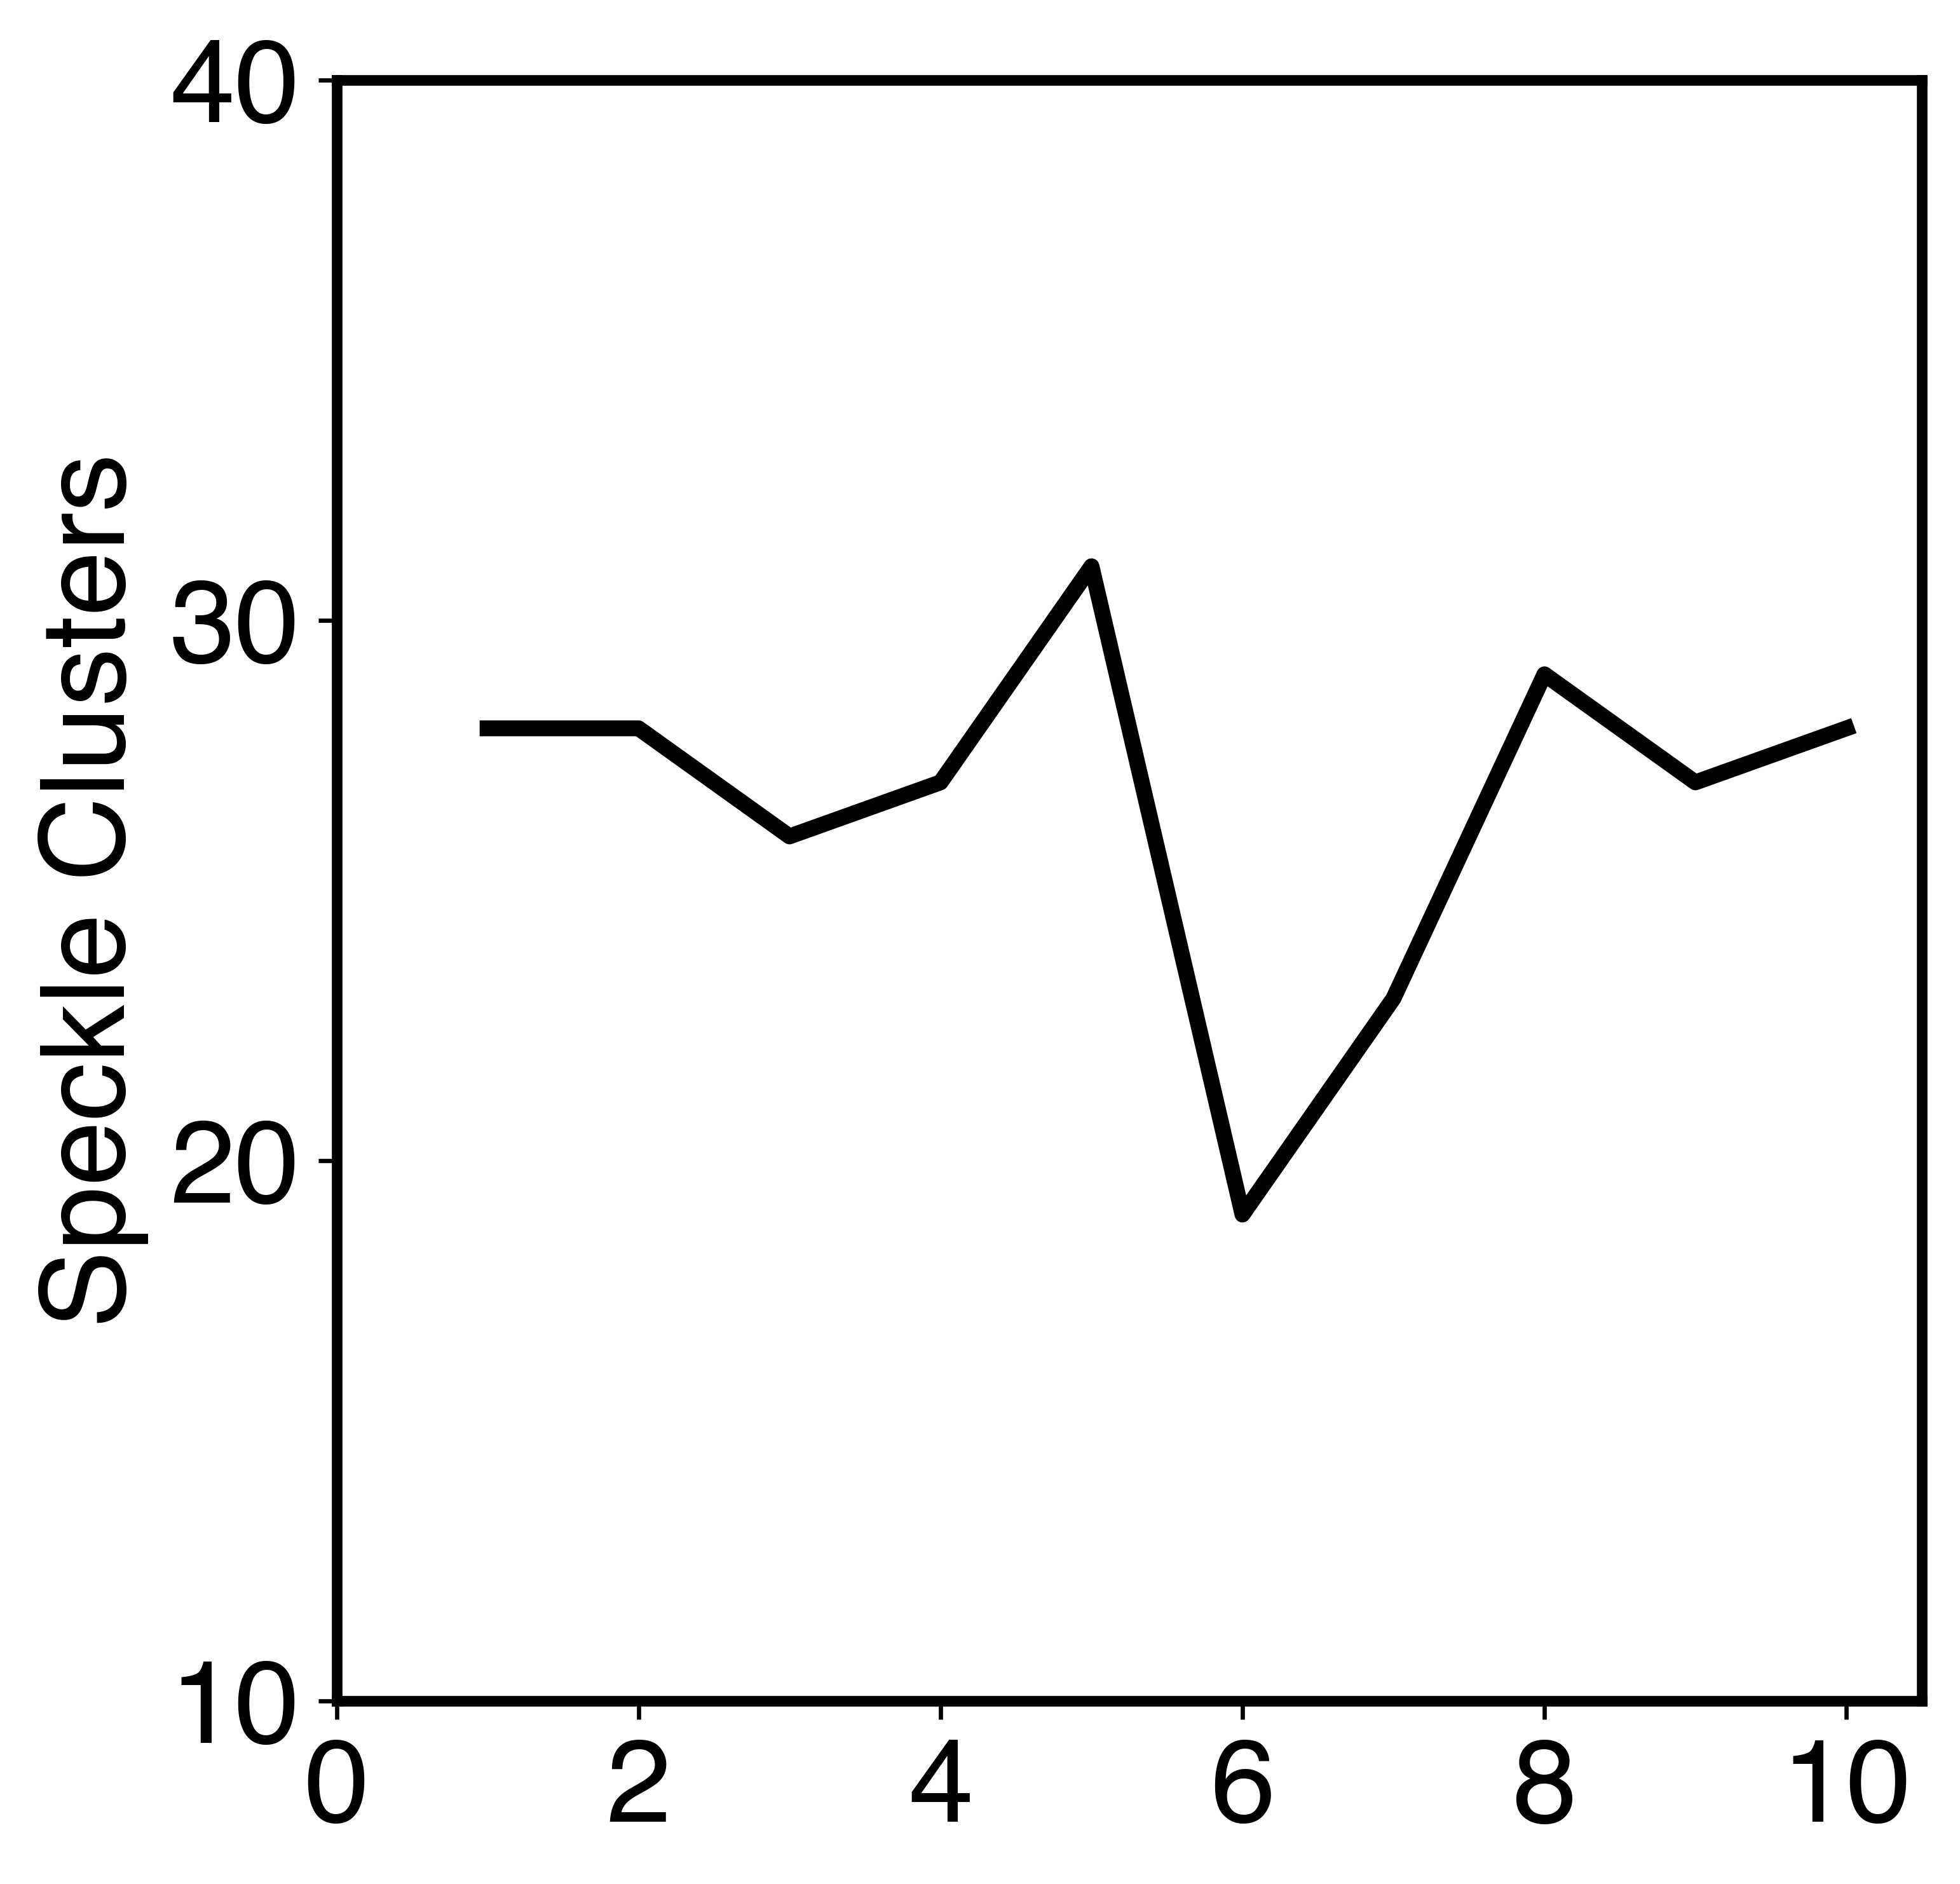

In [11]:
fig=plt.figure(figsize=(5.6,5.4),dpi=600)
plt.plot(np.arange(1,len(n_clusters)+1), n_clusters, c='black', linewidth='3.0')

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.ylim(10, 40)
plt.yticks(np.arange(10,45,10), labels=['10','20','30','40'])
plt.xticks(np.arange(0,10.5,2), labels=['0','2','4','6','8','10'])
plt.xlim(0, 10.5)

plt.ylabel('Speckle Clusters')
plt.tight_layout()
plt.show()
plt.close()

## Compute the chromosome contact probabilities

We compile the Fortran code "OpenNucleome/openNucleome/utility/chromsome_contact_calculation.f90" and analyzed the chromosome-chromosome contact probabilities in the next several blocks.

In [17]:
subprocess.call(["gfortran -o contact_calculation ../../openNucleome/utility/chromosome_contact_calculation.f90"],
                shell=True,stdout=subprocess.PIPE)

0

In the next block, we ran the Fortran code to compute the ideal, compt-compt, and interchromosomal contact probabilities for 10 frames and output three files ('nframes.txt', 'contact_prob.txt', 'counter.txt'), where 'nframes.txt' logs the anazlyzed number of frames, 'contact_prob.txt' logs averaged contact probabilities over different frames, and 'counter.txt' logs the total number of contacts.

In [18]:
# contact_calculation: execution file compiled from Fortran code
# frame_10.dcd: trajectory file
# 1, 10: the analysis starts from 1st frame and ends at 10th frame
# ./contact_prob: save the output in this path
subprocess.call(["./contact_calculation frame_10.dcd 1 10 ./contact_prob/"],
                shell=True,stdout=subprocess.PIPE)

0

We plotted the ideal contact probabilities against experimental results in the next block. Again, this analysis is just an example, so the result will be slightly different from the results in the paper.

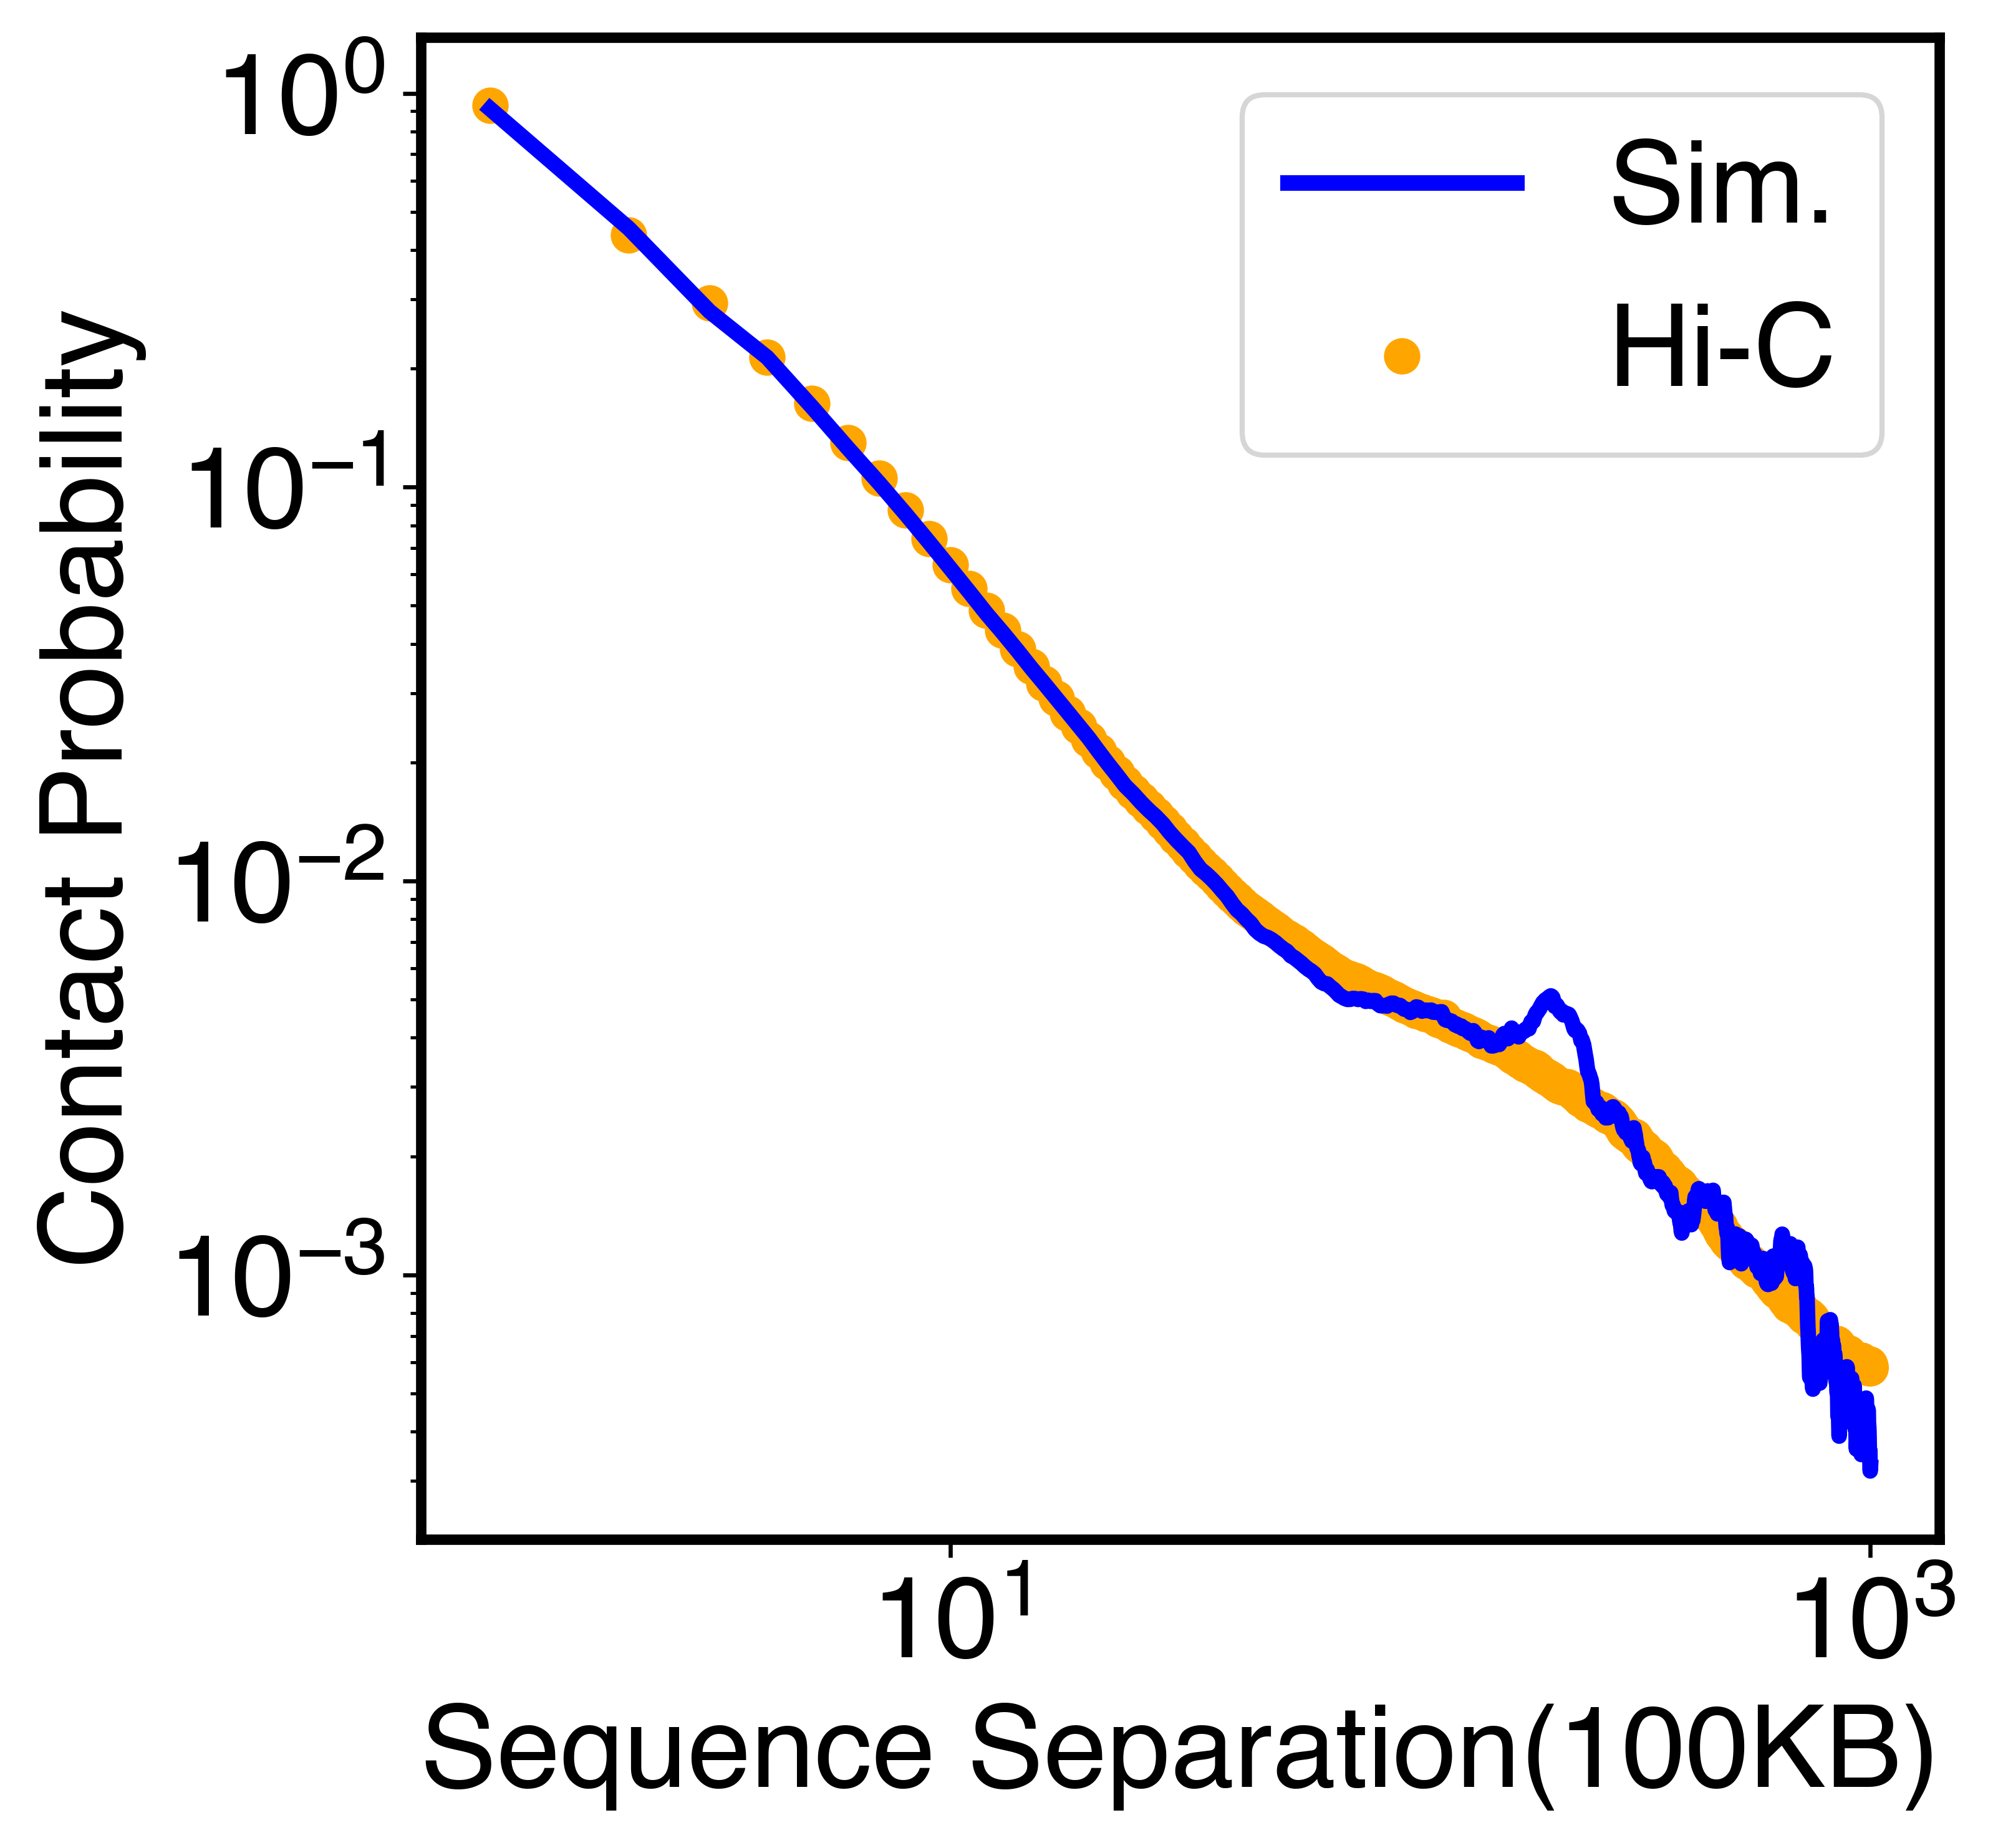

In [3]:
experiment = np.loadtxt('expt_constraints_HFF_100KB.txt')
model = np.loadtxt('./contact_prob/contact_prob.txt')

xaxis = np.arange(1,1001,1)

fig=plt.figure(figsize=(4.7/4.4*5.4,5.4),dpi=600)

plt.scatter(xaxis, experiment[:1000], c='orange',marker='o', label="Hi-C")
plt.plot(xaxis, model[:1000], c='blue', linewidth='3.0', label="Sim.")
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.xlabel('Sequence Separation(100KB)')
plt.ylabel('Contact Probability')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

We plotted the compt-compt contact probabilities against experimental results in the next block.

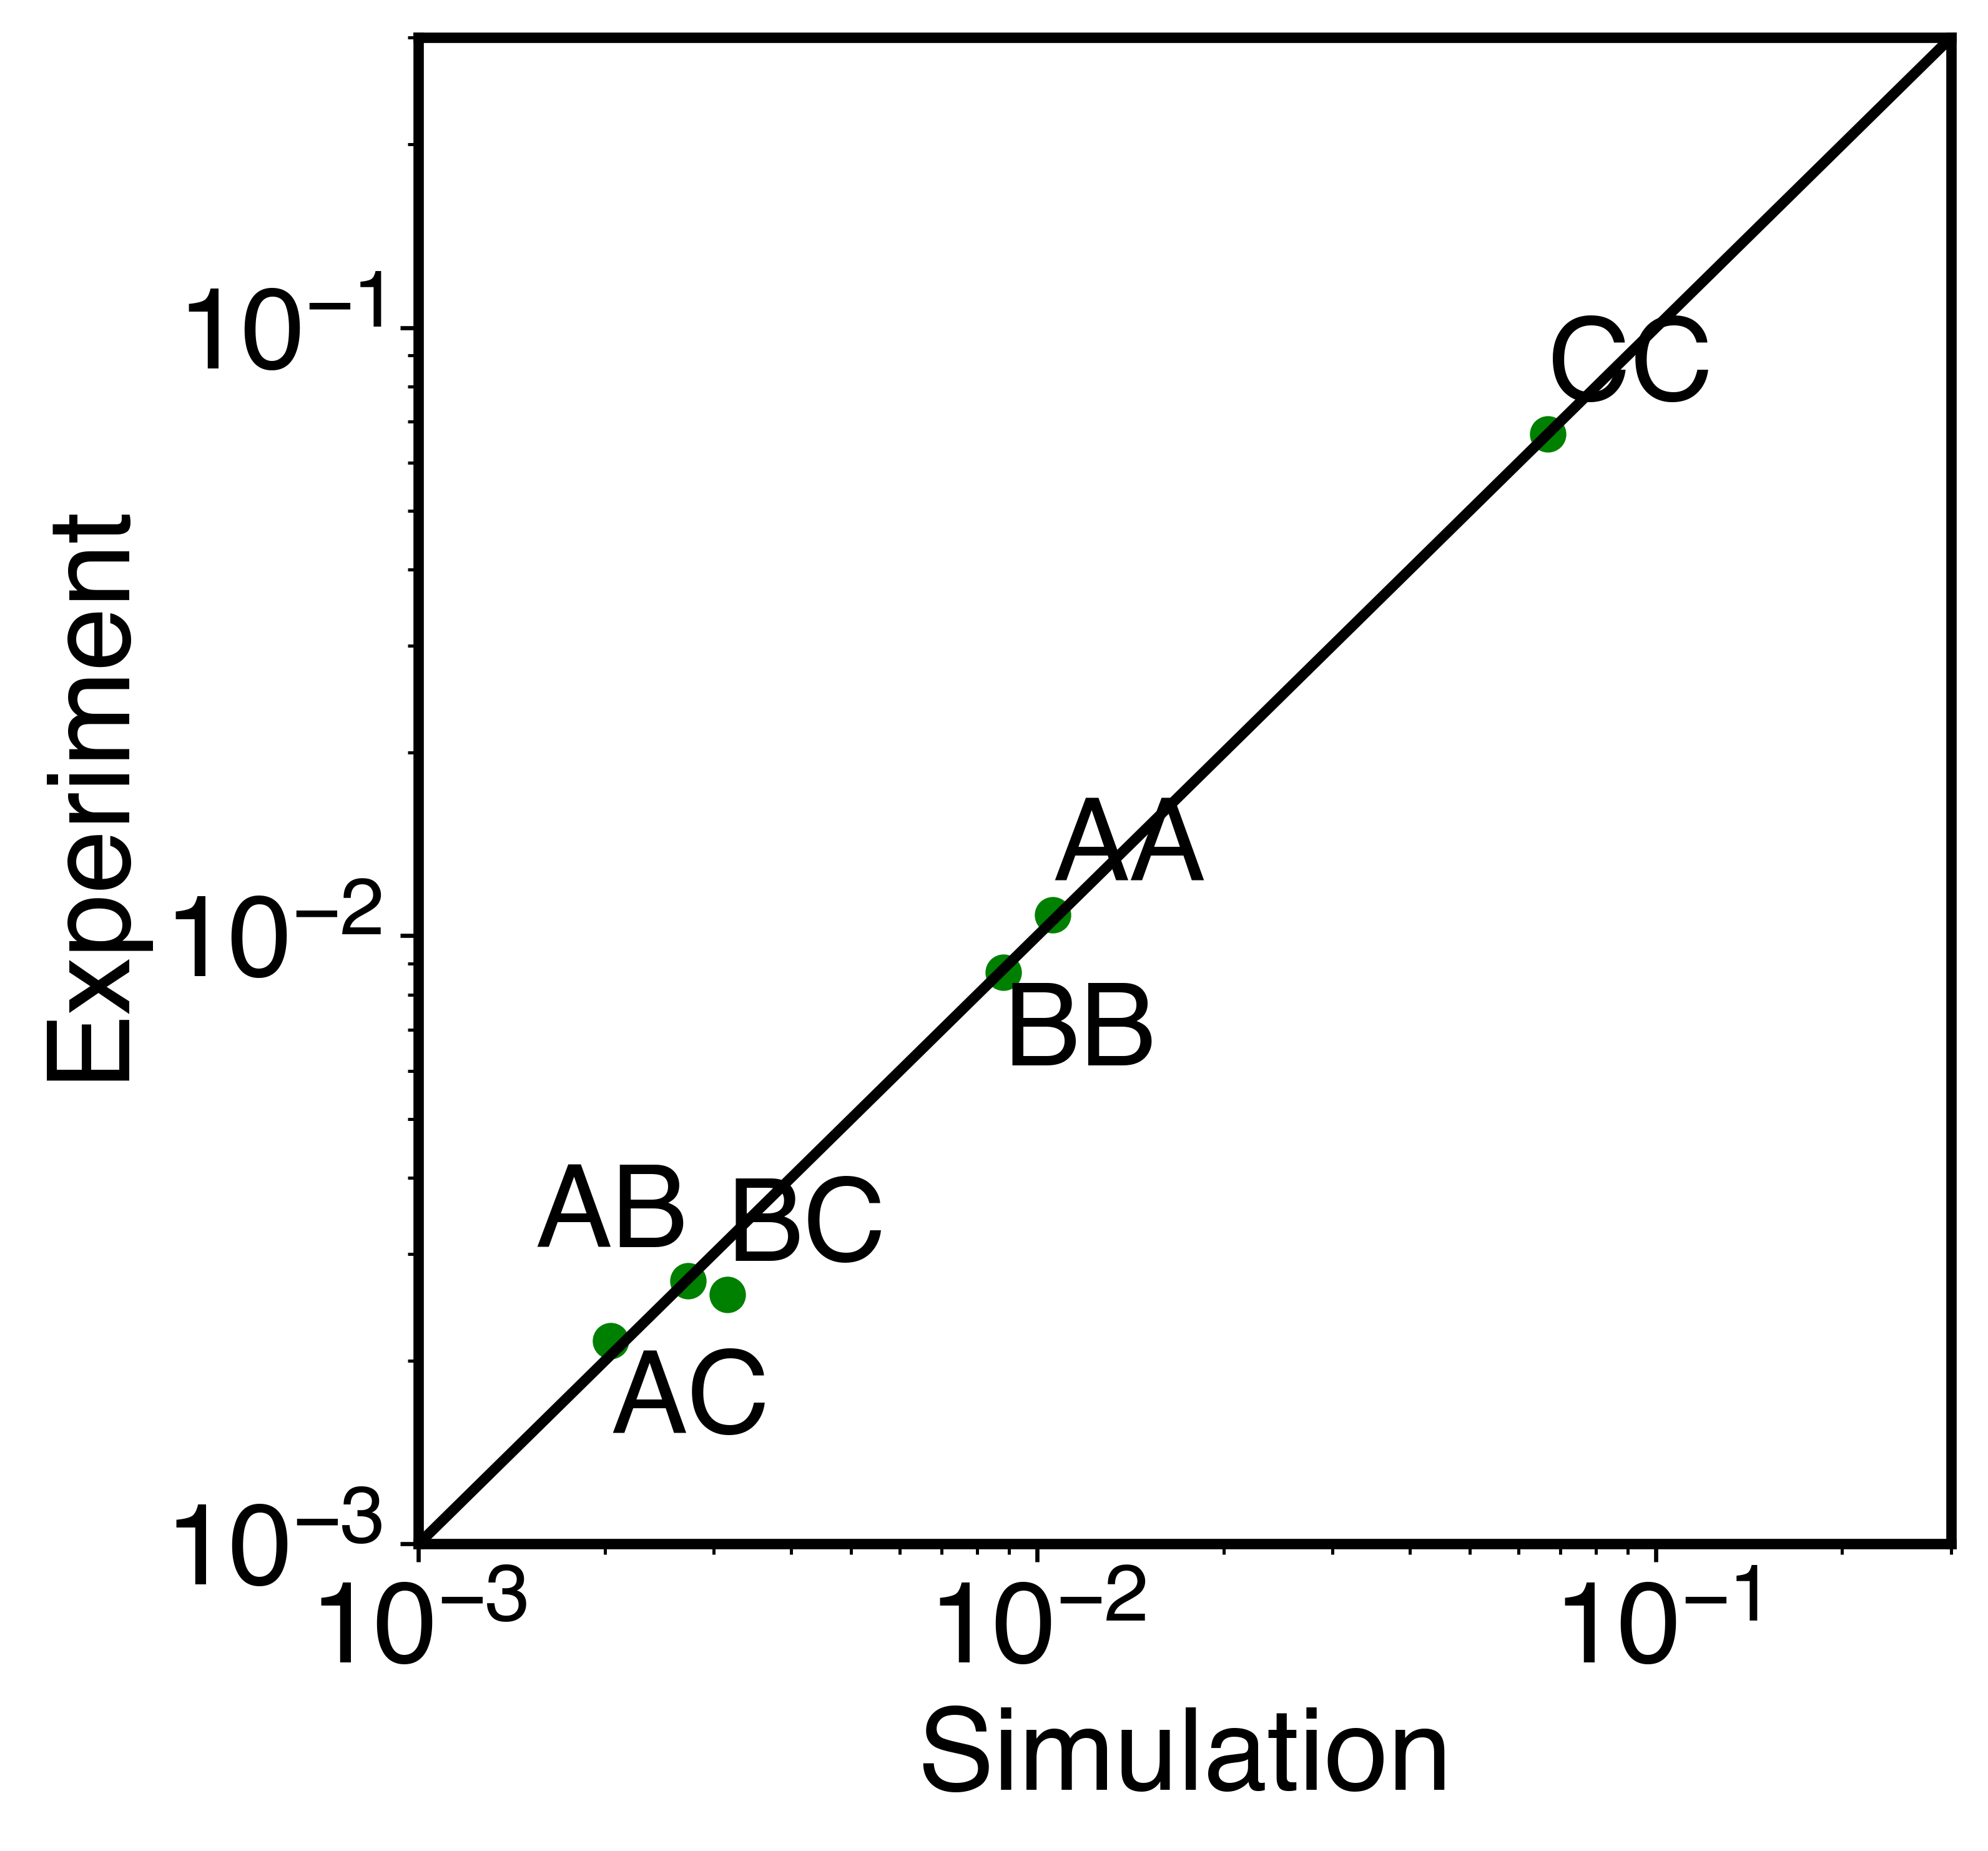

In [4]:
Label = ['AA', 'AB', 'AC', 'BB', 'BC', 'CC']

line_lim = np.linspace(10**-3, 3*10**-1, num=1000, endpoint=True)

fig=plt.figure(figsize=(4.7/4.4*5.4,5.4),dpi=600)
plt.scatter(model[2489:2495], experiment[2489:2495], c='green')
plt.plot(line_lim,line_lim, color='black', linewidth='2.0')
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.xlim(10**-3, 3*10**-1)
plt.ylim(10**-3, 3*10**-1)
plt.xlabel('Simulation')
plt.ylabel('Experiment')
plt.xscale('log')
plt.yscale('log')
texts = []
for i, label in enumerate(Label):
    texts.append(plt.text(model[2489+i],experiment[2489+i],label))
adjust_text(texts, only_move={'points':'y', 'texts':'y'})
plt.tight_layout()
plt.show()
plt.close()

We plotted the interchromosomal contact probabilities against experimental results in the next block.

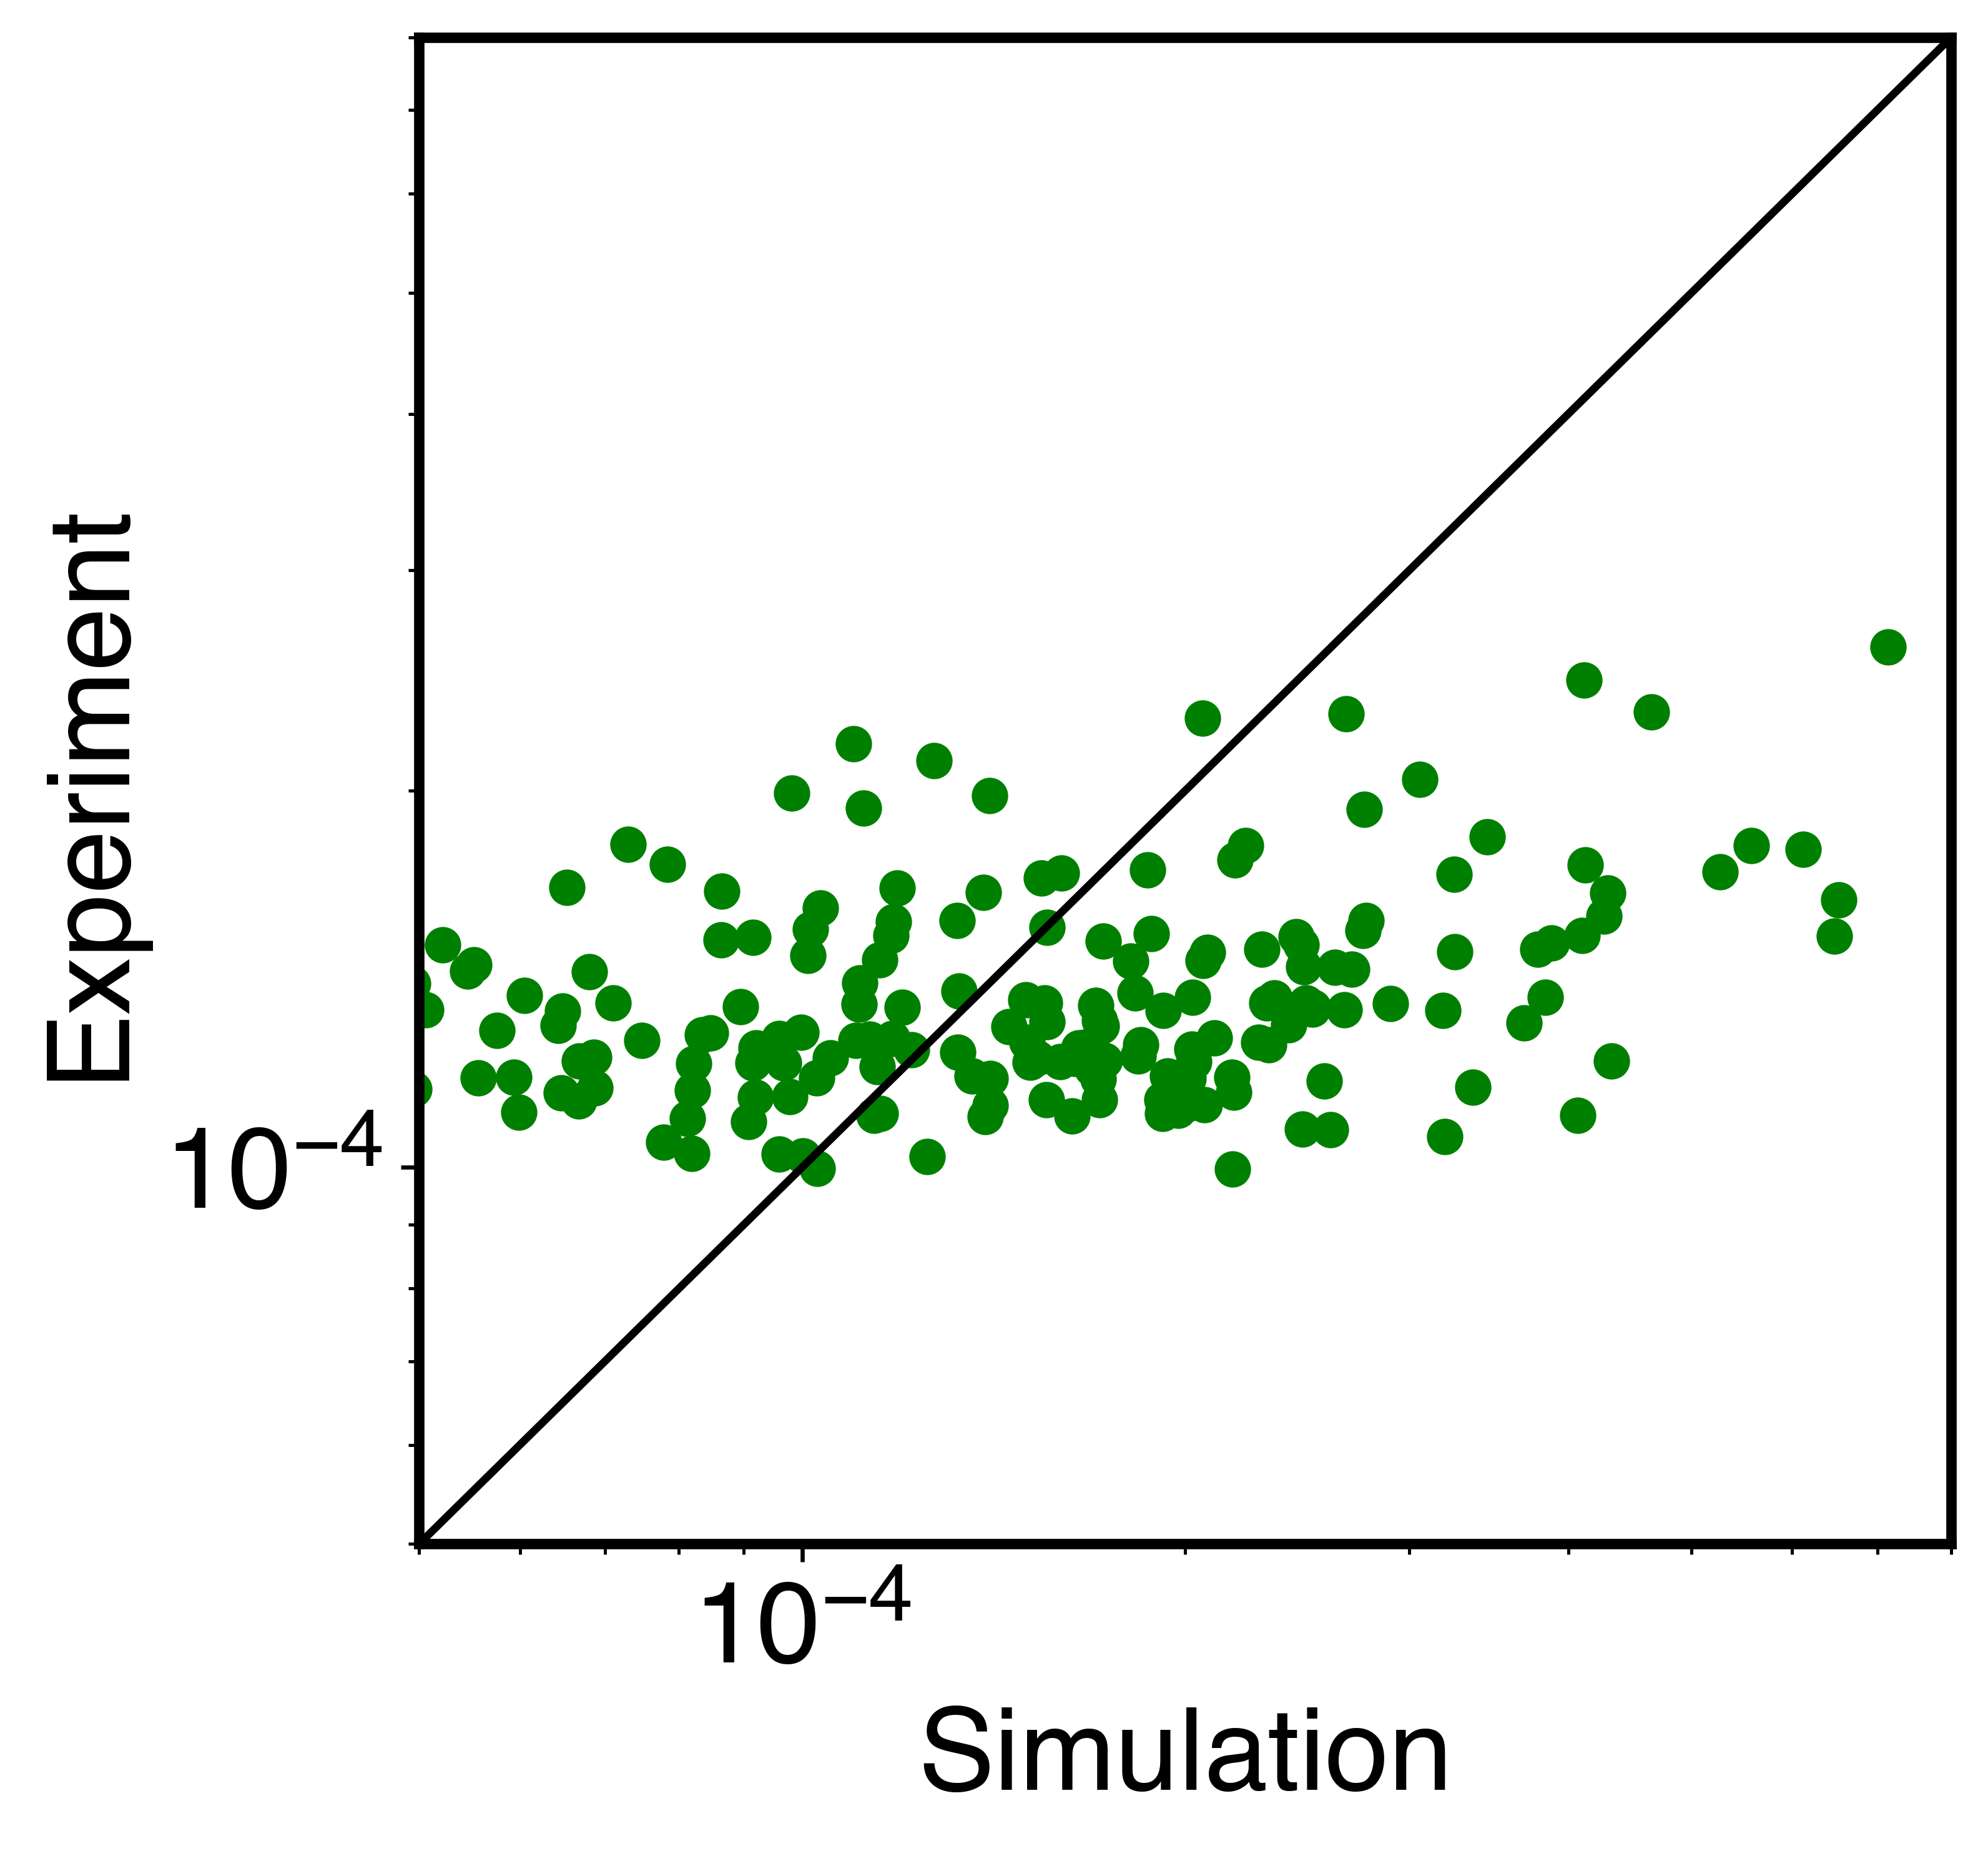

The pearson correlation coefficient is 0.4514592536342756


In [7]:
experiment = model[0]/experiment[0]*experiment

pearson_value = scipy.stats.pearsonr(model[2495:], experiment[2495:])[0]

line_lim = np.linspace(5*10**-5, 8*10**-4, num=1000, endpoint=True)

fig=plt.figure(figsize=(4.7/4.4*5.4,5.4),dpi=600)
plt.scatter(model[2495:], experiment[2495:], c='green')
plt.plot(line_lim,line_lim, color='black')
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.xlim(5*10**-5, 8*10**-4)
plt.ylim(5*10**-5, 8*10**-4)
plt.xlabel('Simulation')
plt.ylabel('Experiment')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()

print("The pearson correlation coefficient is", pearson_value)